In [1]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [2]:

# Load particle tracers
analogTracer: AnalogParticleTracer = pickle.load(open('data/analogTracer2d-simple.pkl', 'rb'))
doseEstimatorK: DoseEstimator = pickle.load(open('data/doseEstimatorK2d-simple.pkl', 'rb'))[0]
kdmc: KDMC = pickle.load(open('data/kdmc2d-simple.pkl', 'rb'))
doseEstimatorKD: DoseEstimator = pickle.load(open('data/doseEstimatorKD2d-simple.pkl', 'rb'))[0]
simDomain: LungSimulationDomain = analogTracer.simDomain  # type: ignore
simOptions: LungInitialConditions = analogTracer.simOptions  # type: ignore
bins = simDomain.xbins
width = simDomain.width

In [3]:
print(analogTracer.averageNbCollisions)

828.0716799999994


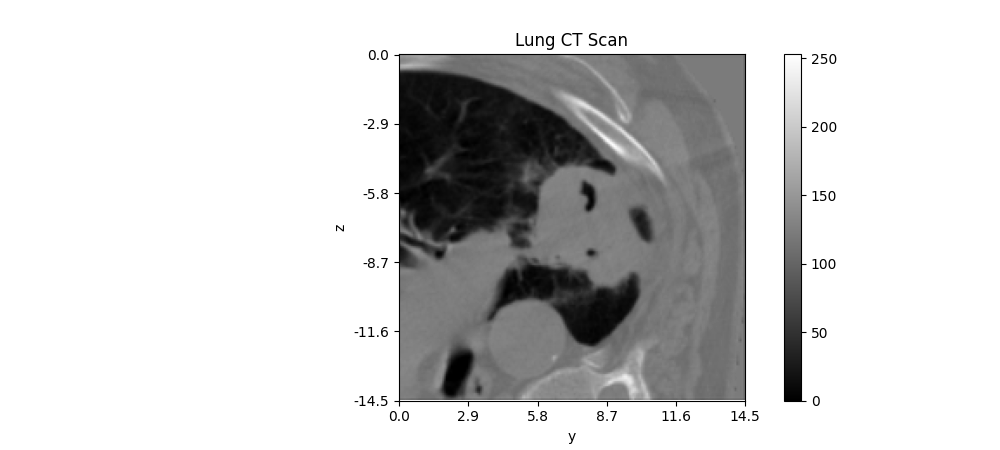

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 4.5))
pos = ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray')  # type: ignore
ax1.set_title('Lung CT Scan')
ax1.set_xlabel('y')
ax1.set_ylabel('z')
nticks = 6
ax1.set_xticks(np.linspace(0, bins, nticks))
ax1.set_xticklabels(np.linspace(0, width, nticks))
ax1.set_yticks(np.linspace(0, bins, nticks))
ax1.set_yticklabels(np.linspace(0, -width, nticks))
fig.colorbar(pos, ax=ax1)


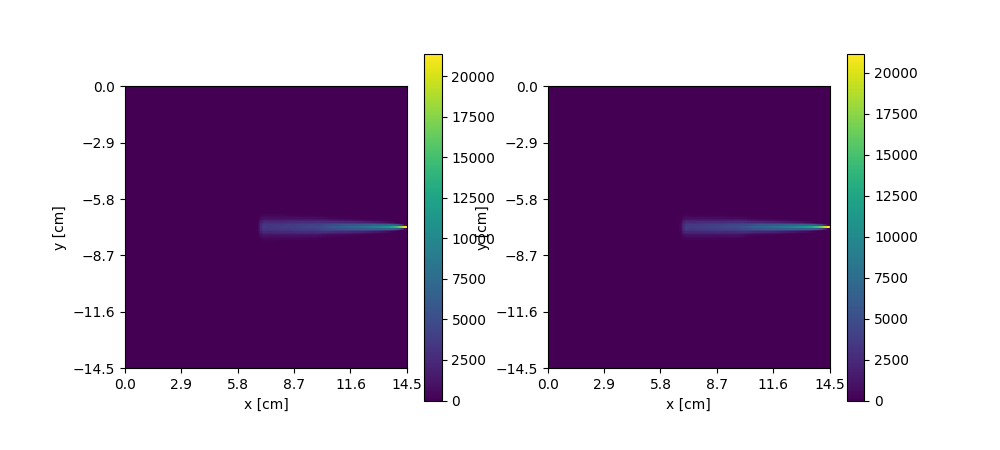

In [5]:
# Plot energy deposition in a subdomain
xBins = np.linspace(0, width, bins+1)
yBins = np.linspace(-width, 0, bins+1)

energyDepositionK_ERE = np.flipud(np.reshape(doseEstimatorK.scoreMatrix, (bins, bins)))
energyDepositionKD_ERE = np.flipud(np.reshape(doseEstimatorKD.scoreMatrix, (bins, bins)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

pox1 = ax1.matshow(energyDepositionK_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax1.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax1.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
fig.colorbar(pox1, ax=ax1)

pox2 = ax2.matshow(energyDepositionKD_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax2.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax2.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')
fig.colorbar(pox2, ax=ax2)


/tmp/ipykernel_7280/2644375823.py:10: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
/tmp/ipykernel_7280/2644375823.py:14: RuntimeWarning: divide by zero encountered in log
  ax2.contourf(X, Y, np.log(energyDepositionKD_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)


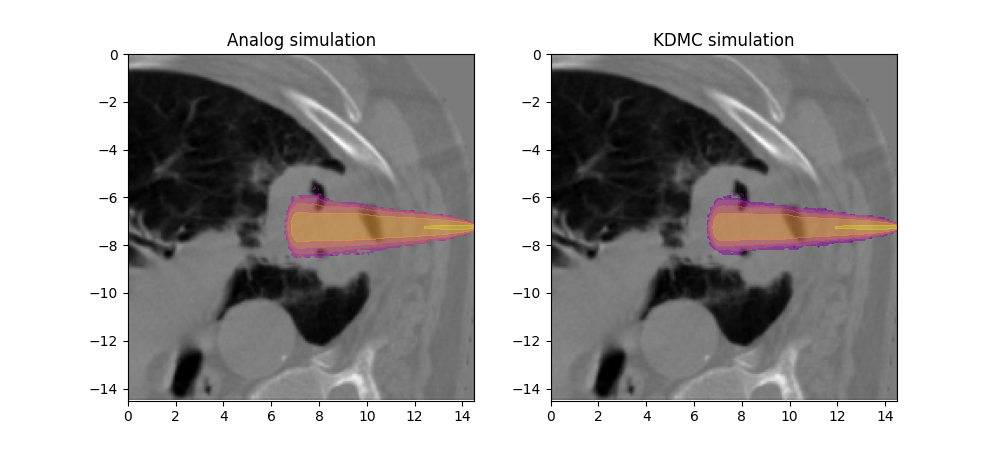

In [20]:
extent = [xBins.min(), xBins.max(), yBins.min(), yBins.max()]
xBins1 = np.linspace(0, width, bins)
yBins1 = np.linspace(-width, 0, bins)
X, Y = np.meshgrid(xBins1, yBins1)
levels = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax1.set_title('Analog simulation')

ax2.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax2.contourf(X, Y, np.log(energyDepositionKD_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax2.set_title('KDMC simulation')
# fig.savefig('Lung2DSimple.jpg')

### Initial direction

In [7]:
testInit = LungInitialConditions()
N = 1000

# Sample a lot of initial vectors
vecs = np.empty((N, 3), dtype=float)
for i in range(N):
    vecs[i, :] = testInit.initialDirection()


(-1.0, 1.0)

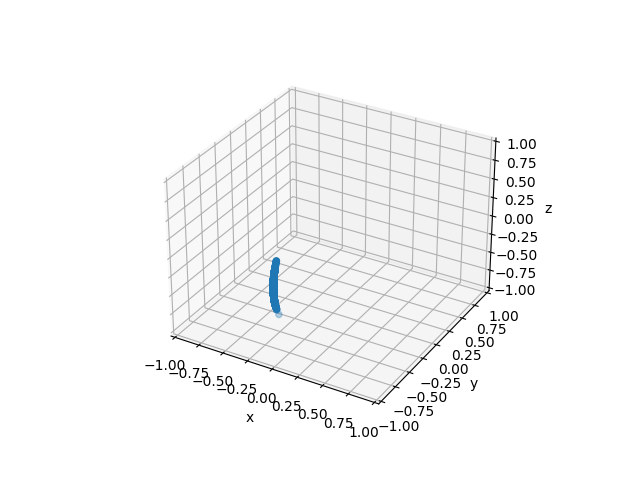

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

### 2d-simple sampling strategy

In [9]:
import sympy as sy
theta = sy.symbols('theta')  # type: ignore
phi = 3*sy.pi/2

xcoor = sy.sin(theta)*sy.cos(phi)  # type: ignore
ycoor = sy.sin(theta)*sy.sin(phi)  # type: ignore
zcoor = sy.cos(theta)

xmean = sy.integrate(xcoor*sy.sin(theta)/2, (theta, 0, sy.pi))  # type: ignore
ymean = sy.integrate(ycoor*sy.sin(theta)/2, (theta, 0, sy.pi))  # type: ignore
zmean = sy.integrate(zcoor*sy.sin(theta)/2, (theta, 0, sy.pi))  # type: ignore

xvar = sy.integrate(((xcoor - xmean)**2)*sy.sin(theta)/(2), (theta, 0, sy.pi))  # type: ignore
yvar = sy.integrate(((ycoor - ymean)**2)*sy.sin(theta)/(2), (theta, 0, sy.pi))  # type: ignore
zvar = sy.integrate(((zcoor - zmean)**2)*sy.sin(theta)/(2), (theta, 0, sy.pi))  # type: ignore

print(f'X: mean: {xmean}   var: {xvar}')
print(f'Y: mean: {ymean}   var: {yvar}')
print(f'Z: mean: {zmean}   var: {zvar}')

X: mean: 0   var: 0
Y: mean: -pi/4   var: 2/3 - pi**2/16
Z: mean: 0   var: 1/3


In [10]:
import math
from electronTransportCode.Material import WaterMaterial

testParticle = SimplifiedEGSnrcElectron(generator=4, scatterer='2d-simple')
N = 1000000
vecs1 = np.empty((N, 3), dtype=float)
for i in range(N):
    mu, phi, _ = testParticle.sampleScatteringAngles(0.5, WaterMaterial)
    sint = math.sqrt(1-mu**2)
    vecs1[i, 0] = sint*math.cos(phi)
    vecs1[i, 1] = sint*math.sin(phi)
    vecs1[i, 2] = mu

print(f'Average x: {np.mean(vecs1[:, 0])}, Variance x: {np.var(vecs1[:, 0])}')
print(f'Average y: {np.mean(vecs1[:, 1])}, Variance y: {np.var(vecs1[:, 1])}')
print(f'Average z: {np.mean(vecs1[:, 2])}, Variance z: {np.var(vecs1[:, 2])}')



Average x: -1.4426439196346713e-16, Variance x: 1.6777996379722428e-33
Average y: -0.7853387717661919, Variance y: 0.04972054435705521
Average z: 0.0008834145290944403, Variance z: 0.33352168878248384


(-1.0, 1.0)

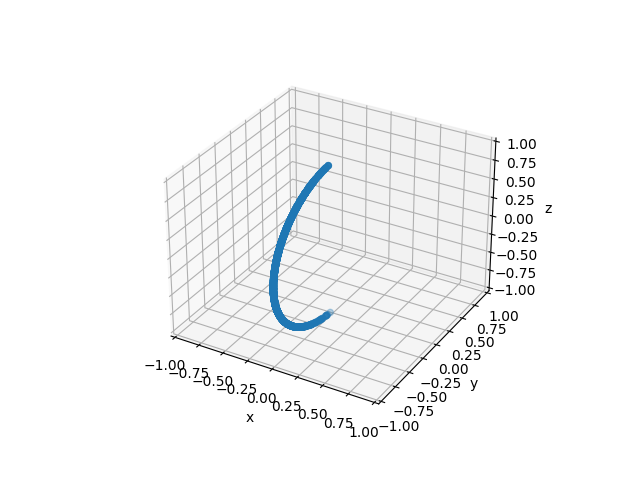

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs1[0:1000, 0], vecs1[0:1000, 1], vecs1[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [12]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
sys.path.append(PROJECT_ROOT)

In [13]:
import math
import numpy as np
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.Material import WaterMaterial
from electronTransportCode.ProjectUtils import I_WATER, ERE
particle = SimplifiedEGSnrcElectron(generator=5)

for i in np.logspace(np.log10(WaterMaterial.I/(ERE*1e6)), 1, 10000000):
    try: 
        particle.evalStoppingPower(i, None, WaterMaterial)
    except AssertionError:
        pass
    except ValueError:
        print(i)

In [14]:
kdmc.particle.getOmegaMoments(None)

(array([ 0.        , -0.78539816,  0.        ]),
 array([0.        , 0.04981639, 0.33333333]))